## 0. Upload Thư Viện

In [5]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Phân loại và lọc Feature

In [2]:
def classify_features(column_names):
    categories = {
        'Physicochemical': [], 
        'VSA_EState': [],      
        'Connectivity': [],    
        'Functional_Groups': [],
        'MACCS_Keys': [],      
        'Other': []            
    }
    
    for col in column_names:
        if 'Morgan' in col:
            continue
            
        if any(x in col for x in ['MolWt', 'LogP', 'TPSA', 'Count_', 'Num', 'Gasteiger']):
            categories['Physicochemical'].append(col)
        elif 'VSA' in col or 'EState' in col:
            categories['VSA_EState'].append(col)
        elif col.startswith(('Chi', 'Kappa', 'topological')):
            categories['Connectivity'].append(col)
        elif col.startswith('fr_') or col.startswith('has_'):
            categories['Functional_Groups'].append(col)
        elif 'MACCS' in col:
            categories['MACCS_Keys'].append(col)
        else:
            categories['Other'].append(col)
            
    return categories

all_features = [
    'Chi0n', 'Chi3v', 'Count_Cl', 'Count_N', 'EState_VSA3', 'MolWt', 'TPSA', 
    'fr_Ar_NH', 'MACCS_101', 'has_halogen', 'topological_diameter'
]

classified = classify_features(all_features)

for group, cols in classified.items():
    print(f"--- {group} ({len(cols)} features) ---")
    print(cols[:5], "..." if len(cols) > 5 else "")

--- Physicochemical (4 features) ---
['Count_Cl', 'Count_N', 'MolWt', 'TPSA'] 
--- VSA_EState (1 features) ---
['EState_VSA3'] 
--- Connectivity (3 features) ---
['Chi0n', 'Chi3v', 'topological_diameter'] 
--- Functional_Groups (2 features) ---
['fr_Ar_NH', 'has_halogen'] 
--- MACCS_Keys (1 features) ---
['MACCS_101'] 
--- Other (0 features) ---
[] 


Nhiệt độ nóng chảy () không chỉ phụ thuộc vào khối lượng phân tử mà còn phụ thuộc vào **lực tương tác liên phân tử** và **cấu trúc mạng tinh thể**. Dưới đây là ý nghĩa của các nhóm feature bạn đã chọn:

* **Nhóm Physicochemical (Lý - Hóa):**
* *MolWt*: Phân tử càng nặng, lực Van der Waals càng lớn, thường dẫn đến  cao hơn.
* *TPSA & LogP*: Quyết định tính phân cực. Các chất có TPSA cao (nhiều nhóm cực) sẽ có tương tác lưỡng cực - lưỡng cực mạnh, làm tăng .
* *NHOHCount*: Đại diện cho khả năng tạo liên kết Hydro — yếu tố quan trọng nhất làm tăng vọt nhiệt độ nóng chảy.


* **Nhóm VSA & EState (Diện tích bề mặt & Điện tử):**
* Các chỉ số này mô tả mật độ electron trên bề mặt phân tử.  phụ thuộc vào việc các bề mặt này "khớp" và hút nhau như thế nào khi ở trạng thái rắn.


* **Nhóm Connectivity (Kết nối & Hình học):**
* *Chi, Kappa, Topological Radius*: Mô tả độ phân nhánh và hình dạng. Phân tử có tính đối xứng cao hoặc ít phân nhánh thường dễ sắp xếp vào mạng tinh thể chặt chẽ hơn, dẫn đến  cao hơn.


* **Nhóm Functional Groups (Nhóm chức):**
* Các biến `fr_` giúp xác định các nhóm đặc hiệu như Amide (`fr_Ar_NH`) hay Halogen. Halogen làm tăng khối lượng và khả năng cực hóa, thường làm tăng .





## 2. Phân tích sâu

Đang tính toán features (vui lòng đợi)...


[17:25:25] WARNING: not removing hydrogen atom without neighbors


Đã phân loại xong các nhóm features.


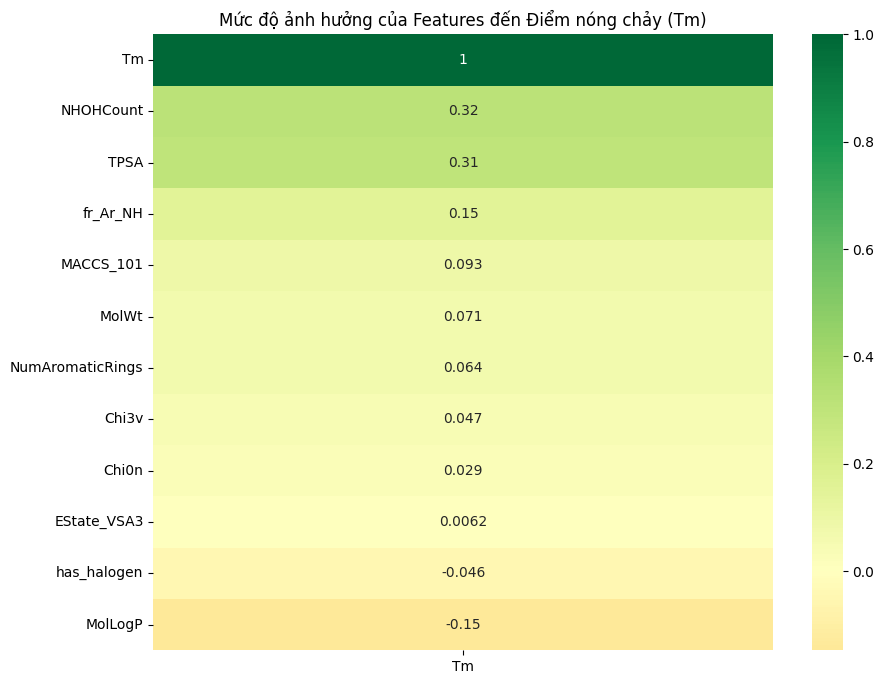

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, MACCSkeys

df = pd.read_csv('melting_point_pubchem.csv')
df['Tm'] = pd.to_numeric(df['Tm'], errors='coerce')
df = df.dropna(subset=['Tm', 'SMILES']).reset_index(drop=True)

def get_chemical_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    
    data = {
        'MolWt': Descriptors.MolWt(mol),
        'TPSA': Descriptors.TPSA(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'NHOHCount': Descriptors.NHOHCount(mol),
        'Chi0n': Descriptors.Chi0n(mol),
        'Chi3v': Descriptors.Chi3v(mol),
        'EState_VSA3': Descriptors.EState_VSA3(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'fr_Ar_NH': Fragments.fr_Ar_NH(mol),
        'has_halogen': 1 if any(atom.GetSymbol() in ['Cl', 'Br', 'I', 'F'] for atom in mol.GetAtoms()) else 0,
        'MACCS_101': int(MACCSkeys.GenMACCSKeys(mol).GetBit(101))
    }
    return pd.Series(data)

print("Đang tính toán features (vui lòng đợi)...")
features_df = df['SMILES'].head(1000).apply(get_chemical_features)
final_df = pd.concat([df[['Tm']].head(1000), features_df], axis=1).dropna()

def classify_features(cols):
    categories = {'Physico': [], 'VSA': [], 'Connectivity': [], 'Groups': [], 'MACCS': []}
    for col in cols:
        if col in ['MolWt', 'TPSA', 'MolLogP', 'NHOHCount']: categories['Physico'].append(col)
        elif 'VSA' in col: categories['VSA'].append(col)
        elif 'Chi' in col: categories['Connectivity'].append(col)
        elif 'fr_' in col or 'has_' in col: categories['Groups'].append(col)
        elif 'MACCS' in col: categories['MACCS'].append(col)
    return categories

print("Đã phân loại xong các nhóm features.")

plt.figure(figsize=(10, 8))
correlation = final_df.corr(method='spearman')
sns.heatmap(correlation[['Tm']].sort_values(by='Tm', ascending=False), 
            annot=True, cmap='RdYlGn', center=0)

plt.title('Mức độ ảnh hưởng của Features đến Điểm nóng chảy (Tm)')
plt.show()